In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import torch
import os
import random

%matplotlib inline
from matplotlib import pyplot as plt

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [29]:
def train_model(model, optimizer, X_train, X_train_lengths, Y_train, X_test, X_test_lengths, Y_test, epochs=500):
    X_train_padded = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)
    X_test_padded = torch.nn.utils.rnn.pad_sequence(X_test, batch_first=True)
    train_accuracy = []
    test_accuracy = []
    train_batch_size = len(X_train_lengths)
    for i in range(epochs):
        model.zero_grad()
        hidden = model.init_hidden(train_batch_size).float()
        output = model(X_train_padded, hidden, X_train_lengths)
        loss = F.cross_entropy(output, Y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        tr_accuracy = test_model(model, X_train, X_train_lengths, Y_train)
        train_accuracy.append(tr_accuracy)
        tst_accuracy = test_model(model, X_test, X_test_lengths, Y_test)
        test_accuracy.append(tst_accuracy)
    
    return model.eval(), train_accuracy, test_accuracy

In [30]:
def test_model(model, X_samp, X_samp_lengths, Y_samp):
    batch_size = len(X_samp_lengths)
    hidden = model.init_hidden(batch_size).float()
    X_samp_padded = torch.nn.utils.rnn.pad_sequence(X_samp, batch_first=True)
    output_test = model(X_samp_padded, hidden, X_samp_lengths)
    total = 0
    correct = 0
    for i, out_t in enumerate(output_test):
        if int(torch.argmax(out_t)) - int(Y_samp[i]) == 0:
            correct = correct + 1
        total = total + 1

    return (correct/total)

In [4]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

filenames = os.listdir("./datasets/names")
names_data = {}

for filename in filenames:
    f = open(f"./datasets/names/{filename}")
    data = f.read()
    names = list(filter(lambda l: len(l) > 0, map(lambda n: unicode_to_ascii(n.strip()).lower().strip(','), data.split("\n"))))
    names_data[filename.strip(".txt").lower()] = names
    f.close()

languages = list(names_data.keys())
languages.sort()


def one_hot_code(name):
    line_vector = []
    for c in name:
        letter_vector = [0] * 28
        i = ord(c) - 97
        if i == ord(" ") - 97:
            letter_vector[26] = 1
        elif i == ord("'") - 97:
            letter_vector[27] = 1
        else:
            letter_vector[i] = 1

        line_vector.append(letter_vector)
    
    return line_vector


def one_hot_to_word(name_vec):
    name = ""
    for letter_vec in name_vec:
        num = np.argmax(letter_vec)
        if num == 26:
            name = name + " "
        elif num == 27:
            name = name + "'"
        else:
            name = name + chr(num + 97)
    
    return name


def label_to_vec(lang):
    label_vec = [0] * len(languages)
    i = languages.index(lang)
    label_vec[i] = 1
    
    return label_vec


def vec_to_label(label_vec):
    i = np.argmax(np.array(label_vec))
    return languages[i]


X_tr = []
X_tst = []
Y_tr = []
Y_tst = []

for lang in languages:
    label_vec = label_to_vec(lang)
    lang_names = names_data[lang]
    random.shuffle(lang_names)
    for name in lang_names[:int(0.8 * len(lang_names))]:
        name_vec = one_hot_code(name)
        X_tr.append(name_vec)
        Y_tr.append(label_vec)
    for name in lang_names[int(0.8 * len(lang_names)):]:
        name_vec = one_hot_code(name)
        X_tst.append(name_vec)
        Y_tst.append(label_vec)

train_indices = list(range(len(X_tr)))
test_indices = list(range(len(X_tst)))
random.shuffle(train_indices)
random.shuffle(test_indices)
X_train = list(map(lambda i: X_tr[i], train_indices))
Y_train = list(map(lambda i: Y_tr[i], train_indices))
X_test = list(map(lambda i: X_tst[i], test_indices))
Y_test = list(map(lambda i: Y_tst[i], test_indices))

In [5]:
one_hot_to_word(X_train[3]), vec_to_label(Y_train[3])

('partington', 'english')

In [6]:
len(languages)

18

In [7]:
train_set = list(zip(X_train, Y_train))

In [8]:
train_set = sorted(train_set, key=lambda t: len(t[0]), reverse=True)

In [9]:
test_set = list(zip(X_test, Y_test))

In [10]:
test_set = sorted(test_set, key=lambda t: len(t[0]), reverse=True)

In [11]:
X_train = []
X_train_lengths = []
Y_train = []
X_test = []
X_test_lengths = []
Y_test = []
for x, y in train_set:
    X_train.append(torch.tensor(x).float().to(device))
    X_train_lengths.append(len(x))
    Y_train.append(np.argmax(torch.tensor(y)))

Y_train = torch.tensor(Y_train).to(device)

for x, y in test_set:
    X_test.append(torch.tensor(x).float().to(device))
    X_test_lengths.append(len(x))
    Y_test.append(np.argmax(torch.tensor(y)))

Y_test = torch.tensor(Y_test).to(device)

In [12]:
X_train_padded = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)
X_test_padded = torch.nn.utils.rnn.pad_sequence(X_test, batch_first=True)

In [13]:
X_train_padded_packed = torch.nn.utils.rnn.pack_padded_sequence(X_train_padded, X_train_lengths, batch_first=True)

In [14]:
X_train_padded_packed

PackedSequence(data=tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), batch_sizes=tensor([16053, 16053, 16014, 15742, 14688, 12491,  9358,  6398,  3960,  2151,
          971,   419,   170,    73,    39,    26,    22,     2]), sorted_indices=None, unsorted_indices=None)

In [31]:
class ModelOne(nn.Module):
    
    def __init__(self):
        super(ModelOne, self).__init__()
        self.rnn = nn.RNN(28, 128, 4, batch_first=True)
        self.dense = nn.Linear(128, 18)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(4, batch_size, 128).to(device)

        return hidden
    
    def forward(self, x, hidden, x_lengths):
        batch_size = x.size(0)
        max_sequence_size = x.size(1)
        # hidden = self.init_hidden(batch_size).float()
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_lengths, batch_first=True)
        out, hidden = self.rnn(x, hidden)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = out.contiguous()
        out = out.view(-1, 128)
        out = self.dense(out)
        out = out.view(batch_size, max_sequence_size, 18)
        
        indexes = torch.tensor(x_lengths) - 1
        out = out[torch.arange(batch_size), indexes, :]
        
        return F.softmax(out, dim=1)

In [35]:
model_one = ModelOne().to(device)

In [364]:
output = model_one(X_train_padded, X_train_lengths)

In [365]:
len(output)

16053

In [366]:
output.size()

torch.Size([16053, 18])

In [367]:
output[0]

tensor([0.0553, 0.0519, 0.0628, 0.0535, 0.0580, 0.0517, 0.0587, 0.0560, 0.0576,
        0.0484, 0.0504, 0.0604, 0.0506, 0.0488, 0.0542, 0.0706, 0.0546, 0.0567],
       grad_fn=<SelectBackward>)

In [18]:
one_hot_to_word(X_train[0]), languages[int(Y_train[0])]

('shirinskyshikhmatov', 'russian')

In [36]:
optimizer = optim.Adam(model_one.parameters(), lr=0.001)
model_one, train_accuracy, test_accuracy = train_model(model_one, optimizer, X_train, X_train_lengths, Y_train, X_test, X_test_lengths, Y_test, epochs=10)

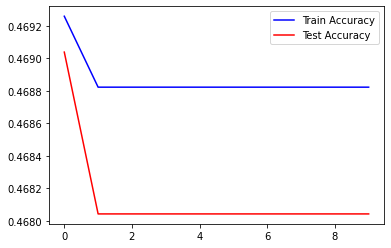

In [37]:
fig, ax = plt.subplots()
ax.plot(train_accuracy, "b-", label="Train Accuracy")
ax.plot(test_accuracy, "r-", label="Test Accuracy")
leg = ax.legend()